## Show bias in single reference for DeepSHAP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
import keras

import shap

#################
### Load Data ###
#################
# Model parameters
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

# Preprocess data
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

##################
### Load Model ###
##################
from model import cifar_cnn
model = cifar_cnn()

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
10000/10000 [==============================] - 1s 136us/sample - loss: 0.7515 - acc: 0.7556
Test loss: 0.7514849551200866
Test accuracy: 0.7556


Actual Category: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Predict Category: [[0.16149051 0.00278377 0.05986948 0.386509   0.04066185 0.23362775
  0.05066405 0.04187838 0.01809062 0.0044246 ]]
***Black Baseline***
***Average Baseline***


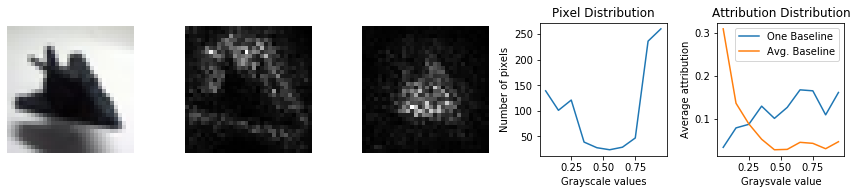

Actual Category: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], Predict Category: [[6.6741748e-04 2.2181350e-06 9.9716574e-01 3.4143985e-04 4.3058762e-04
  1.2803073e-03 1.2956566e-06 1.0029098e-04 5.5072733e-06 5.1935067e-06]]
***Black Baseline***
***Average Baseline***


/homes/gws/hughchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice.
/homes/gws/hughchen/anaconda2/envs/tf36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gws/hughchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice.


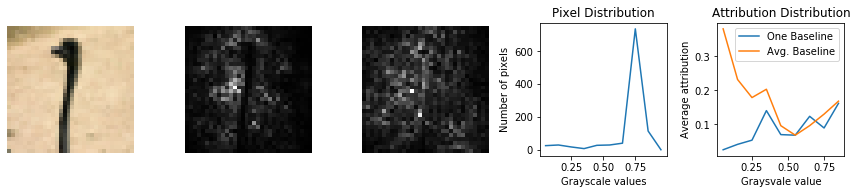

Actual Category: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], Predict Category: [[4.2601584e-07 2.3130096e-09 2.4003548e-06 1.3752538e-06 9.4975115e-07
  2.9291261e-05 1.4114999e-09 9.9996531e-01 7.9417507e-11 1.0602411e-07]]
***Black Baseline***
***Average Baseline***


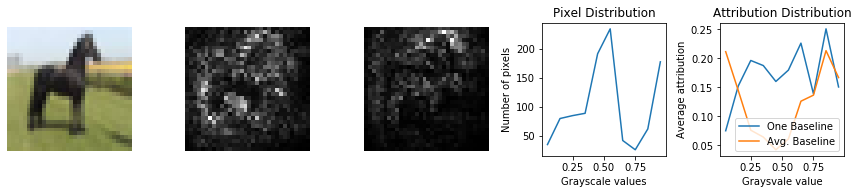

In [15]:
fig_path = "fig/deepshap/"

def plot_img(img, is_gray=True):
    plt.axis('off')
    if is_gray:
        plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    else:
        plt.imshow(img, vmin=0, vmax=1)
    
plt.rcParams["figure.figsize"] = (12,2.8)
for i in [29, 41, 172]:
    plt.clf()
    sample = x_train[i:i+1]
    label  = y_train[i]
    y_pred = model.predict(sample)
    print('Actual Category: %s, Predict Category: %s' % (label, y_pred))
    plt.subplot(1,5,1)
    plot_img(sample[0])

    print("***Black Baseline***")
    ##################
    # Black baseline #
    ##################
    explainer = shap.DeepExplainer(model, np.zeros(x_train[0:1].shape)) # Black baseline
    sv = explainer.shap_values(sample)         # Get attributions for all pixels and channels
    class_sv = np.abs(sv[np.argmax(label)][0]) # Take absolute value for correct output
    sv_img_one = class_sv.mean(2)              # Average across channels
    sv_img_one = sv_img_one/sv_img_one.max()   # Normalize
    plt.subplot(1,5,2)
    plot_img(sv_img_one, is_gray=True)

    ####################
    # Average baseline #
    ####################
    stepsize = 1000
    print("***Average Baseline***")
    explainer = shap.DeepExplainer(model, x_train[np.random.choice(x_train.shape[0],stepsize,replace=False)])
    sv = explainer.shap_values(sample)         # Get attributions for all pixels and channels
    class_sv = np.abs(sv[np.argmax(label)][0]) # Take absolute value for correct output
    sv_img_avg = class_sv.mean(2)              # Average across channels
    sv_img_avg = sv_img_avg/sv_img_avg.max()   # Normalize
    plt.subplot(1,5,3)
    plot_img(sv_img_avg, is_gray=True)

    ####################################
    ### Quantitative measure of bias ###
    ####################################
    import cv2

    # Get gray scale version of the image
    gray = cv2.cvtColor(sample[0], cv2.COLOR_BGR2GRAY)

    # Get histograms
    counts, bins = np.histogram(gray.flatten(),bins=10, range=[0,1])
    bin_means    = (bins[:-1] + bins[1:])/2
    plt.subplot(1,5,4)
    plt.plot(bin_means, counts)
    plt.title("Pixel Distribution")
    plt.xlabel("Grayscale values")
    plt.ylabel("Number of pixels")
    plt.tight_layout()

    # Get attribution sums for one baseline
    plt.subplot(1,5,5)
    attr_sums = []
    for bin_left, bin_right in zip(bins[:-1], bins[1:]):
        within_bin = (gray >= bin_left) & (gray <= bin_right)
        attr_sums.append(sv_img_one[within_bin].mean())
    plt.plot(bin_means, attr_sums, label="One Baseline")

    # Get attribution sums for many baselines
    attr_sums = []
    for bin_left, bin_right in zip(bins[:-1], bins[1:]):
        within_bin = (gray >= bin_left) & (gray <= bin_right)
        attr_sums.append(sv_img_avg[within_bin].mean())
    plt.plot(bin_means, attr_sums, label="Avg. Baseline")

    # Title plot
    plt.title("Attribution Distribution")
    plt.xlabel("Graysvale value")
    plt.ylabel("Average attribution")
    plt.tight_layout()
    plt.legend()
    plt.savefig("{}img{}.pdf".format(fig_path,i), bbox_inches='tight', pad_inches=0.1)
    plt.show()